# Seq2seq으로 번역기 만들기

In [1]:
import time
import re
import os
import io
import random

import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tqdm import tqdm

print(tf.__version__)

2.6.0


matplotlib와 sns 설정

In [2]:
# seaborn에 한글 지원 폰트 설정
# sns.set(font='Malgun Gothic')
sns.set(font='NanumGothic')

# 마이너스 부호 올바르게 표시하기 위한 설정
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(15, 15))

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

## 데이터 전처리

### 데이터 확인

In [3]:
path_to_zip = tf.keras.utils.get_file(
    'korean-english-park.train.tar.gz',
    origin='https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz',
    extract=True)

en_path_to_file = os.path.dirname(path_to_zip)+"/korean-english-park.train.en"
ko_path_to_file = os.path.dirname(path_to_zip)+"/korean-english-park.train.ko"

In [4]:
with open(en_path_to_file) as f:
    en_raw = f.read().splitlines()

print('Data size: ', len(en_raw))
print('Example: ')

for i, sen in enumerate(en_raw[:10]):
    print(f'{i+1}::{sen}')

Data size:  94123
Example: 
1::Much of personal computing is about "can you top this?"
2::so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.
3::Like all optical mice, But it also doesn't need a desk.
4::uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.
5::Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack.
6::After learning of several foiled al Qaeda attempts on U.S. and commercial ships in the area, experts are warning that the terror network still wants to cripple the global economy, the world's economic jugular vein in Southeast Asia is at risk.
7::Caffeine can help increase reaction time and improve performance for military servicemen who must perform complex tasks or who need help s

In [5]:
with open(ko_path_to_file) as f:
    ko_raw = f.read().splitlines()

print('Data size: ', len(ko_raw))
print('Example: ')

for i, sen in enumerate(ko_raw[:10]):
    print(f'{i+1}::{sen}')

Data size:  94123
Example: 
1::개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
2::모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
3::그러나 이것은 또한 책상도 필요로 하지 않는다.
4::79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
5::정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
6::이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 (테러) 시도 중 여러 건이 실패했다는 것을 알게 된 후에, 전문가들은 테러 조직이 여전히 세계 경제에 타격을 입히려 한다고 경고하고 있으며, 동남 아시아에 있는 세계 경제의 주요 통로가 위험에 처해 있다고 그들은 생각하고 있다.
7::국립 과학 학회가 발표한 새 보고서에따르면, 복잡한 임무를 수행해야 하는 군인들이나 보다 오랜 시간 동안 경계를 늦추지 않고 있기 위해 도움이 필요한 군인들에게 카페인이 반응 시간을 증가시키고 임무 수행 능력을 향상시키는데 도움이 된다고 한다.
8::이 보고서에따르면, "특히, 군사 작전에서 생사가 걸린 상황이 될 수도 있는 반응 속도와 시각 및 청각의 경계 상태를 유지시키기 위해 카페인이 사용될 수도 있다." 고 한다.
9::"결정적인 순간에 그들의 능력을 증가시켜 줄 그 무엇이 매우 중요합니다."
10::연구가들이 이미 커피 대체품으로서 음식 대용 과자나 껌에 카페인을 첨가하는 방법을 연구하고 있다고 Archibald는 말했다.


### 데이터 가공

In [6]:
from konlpy.tag import Mecab

# 전처리 함수
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

# Mecab 객체 생성
mecab = Mecab()

# 중복 제거하고 전처리
cleaned_corpus = list(set(zip(ko_raw, en_raw)))  # 중복 제거
cleaned_ko, cleaned_en = zip(*cleaned_corpus)  # 병렬 쌍 유지

assert len(cleaned_ko)==len(cleaned_en), "단어 개수 틀림"

# 전처리 적용
cleaned_ko = [preprocess_sentence(sentence) for sentence in cleaned_ko]
cleaned_en = [preprocess_sentence(sentence, s_token=True, e_token=True) for sentence in cleaned_en]

# 토큰화
tokenized_ko = [mecab.morphs(sentence) for sentence in cleaned_ko]
tokenized_en = [sentence.split() for sentence in cleaned_en]  # split() 함수를 이용해 토큰화


결과 확인

In [7]:
tokenized_ko[0], cleaned_ko[0]

(['잡스',
  '는',
  '성명',
  '에서',
  '회계',
  '연도',
  '전반기',
  '매출액',
  '이',
  '억',
  '달러',
  '를',
  '기록',
  '했다',
  '며',
  '앞',
  '으로',
  '도',
  '멋진',
  '제품',
  '들',
  '을',
  '시장',
  '에',
  '선보일',
  '예정',
  '이',
  '라고',
  '밝혔',
  '다',
  '.'],
 '잡스는 성명에서 회계연도 전반기 매출액이 억 달러를 기록했다 며 앞으로도 멋진 제품들을 시장에 선보일 예정 이라고 밝혔다 .')

In [8]:
tokenized_en[0], cleaned_en[0]

(['<start>',
  'With',
  'over',
  'billion',
  'in',
  'revenue',
  'for',
  'the',
  'first',
  'half',
  'of',
  'our',
  'fiscal',
  'year',
  ',',
  'we',
  'have',
  'strong',
  'momentum',
  'to',
  'launch',
  'some',
  'terrific',
  'new',
  'products',
  'in',
  'the',
  'coming',
  'quarters',
  ',',
  'Jobs',
  'said',
  'in',
  'a',
  'statement',
  '.',
  '<end>'],
 '<start> With over billion in revenue for the first half of our fiscal year , we have strong momentum to launch some terrific new products in the coming quarters , Jobs said in a statement . <end>')

길이 분포 확인

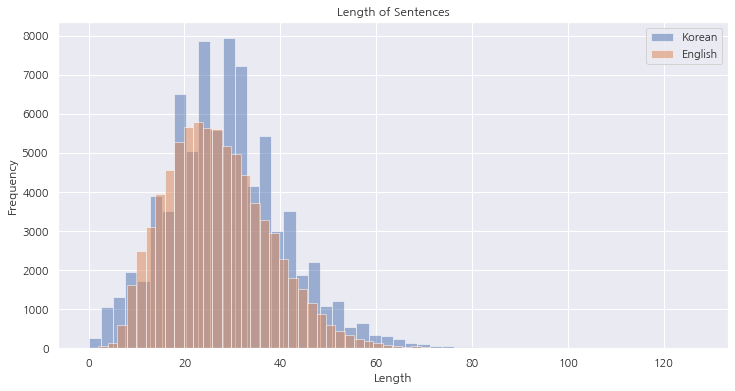

In [9]:
# 문장 길이 리스트를 만듭니다.
ko_lengths = [len(s) for s in tokenized_ko]
en_lengths = [len(s) for s in tokenized_en]

# 히스토그램으로 문장 길이 분포를 시각화합니다.
plt.figure(figsize=(12, 6))
plt.hist(ko_lengths, bins=50, alpha=0.5, label='Korean')
plt.hist(en_lengths, bins=50, alpha=0.5, label='English')
plt.title('Length of Sentences')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

40 이상의 토큰을 삭제  
단, 쌍은 유지

In [10]:
# 토큰의 길이가 40 이하인 데이터만 선별하고, 
#tokenized_ko와 tokenized_en의 쌍을 유지합니다.
filtered_ko = []
filtered_en = []
for ko_sen, en_sen in zip(tokenized_ko, tokenized_en):
    if len(ko_sen) <= 40 and len(en_sen) <= 40:
        filtered_ko.append(ko_sen)
        filtered_en.append(en_sen)

tokenized_ko = filtered_ko
tokenized_en = filtered_en

다시 분포 확인

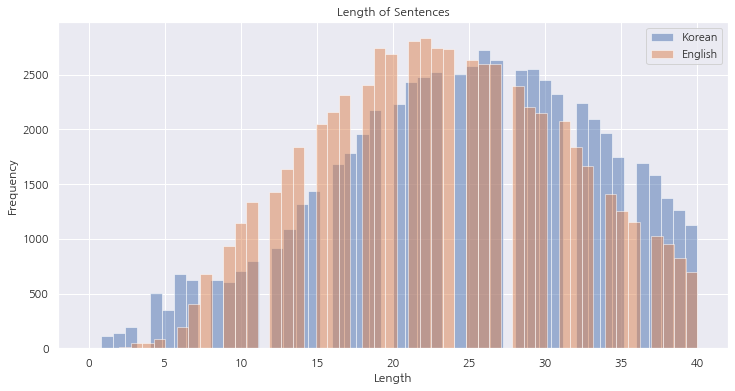

In [11]:
# 문장 길이 리스트를 만듭니다.
ko_lengths = [len(s) for s in tokenized_ko]
en_lengths = [len(s) for s in tokenized_en]

# 히스토그램으로 문장 길이 분포를 시각화합니다.
plt.figure(figsize=(12, 6))
plt.hist(ko_lengths, bins=50, alpha=0.5, label='Korean')
plt.hist(en_lengths, bins=50, alpha=0.5, label='English')
plt.title('Length of Sentences')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

갯수 확인

In [12]:
len(tokenized_en), len(tokenized_ko)

(62750, 62750)

In [13]:
len(tokenized_en), len(tokenized_ko)

(62750, 62750)

정수화

In [14]:
# 시퀀스와 토크나이저 생성
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [15]:
# 정수화된 텐서와 토크나이저
tensor_ko, tokenizer_ko = tokenize(tokenized_ko)
tensor_en, tokenizer_en = tokenize(tokenized_en)

### 정리

지금까지의 과정을 통해 텍스트 전처리가 수행되었다.

1. 중복된 데이터 제거
2. 정규표현식을 통한 데이터 전처리 (이를 위해 영어와 한국어를 모두 케어할 수 있도록 정규식 수정)
3. 한국어는 형태소 분석기, 영어는 공백 기반으로 토큰화
4. 길이분포를 이용해 지나치게 토큰 수가 많은 데이터 제거
5. 지금까지 준비된 코퍼스를 정수화

각 언어별 특징을 고려한 토큰화와 불필요한 문장 부호 제거 등을 통해 
데이터 클리닝을 위한 전처리가 충분히 잘 이루어졌다고 생각한다.

## 모델 설계

### 어텐션, 인코더, 디코더

In [16]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [17]:
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        self.w_com = tf.keras.layers.Dense(units)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_dec = tf.expand_dims(h_dec, 1)
        score = tf.matmul(h_enc, h_dec, transpose_b=True)
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn


In [18]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dropout_rate=0.3, mode='gru'):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        
        # mode에 따라 레이어 변경
        # 모드가 잘못 입력되면 모델 생성 불가
        self.mode = mode
        assert mode in ['gru', 'lstm'], 'wrong mode'
        
        
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)
        self.lstm = tf.keras.layers.LSTM(enc_units, 
                                             return_sequences=True, 
                                             return_state=True)

        # dropout이 추가됨
        self.dropout_rate = dropout_rate
        
        if dropout_rate is not None:
            self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
    def call(self, x):
        out = self.embedding(x)
        # dropout이 추가됨
        if self.dropout_rate is not None:
            out = self.dropout(out)
        
        if self.mode == 'gru':
            out = self.gru(out)
        elif self.mode == 'lstm':
            out, _, _ = self.lstm(out)  # LSTM의 출력과 두 상태를 반환합니다.
        
        return out

In [19]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, dropout_rate=0.3, mode='gru', attention='b'):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        
        # 모드 변수 설정이 잘못되면 생성 불가
        self.mode = mode
        assert mode in ['gru', 'lstm'], 'wrong mode'
        
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.lstm = tf.keras.layers.LSTM(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # dropout이 추가됨
        self.dropout_rate = dropout_rate
        if dropout_rate is not None:
            self.dropout = tf.keras.layers.Dropout(dropout_rate)

        
        # 잘못된 인자 차단
        assert attention in ['b', 'l'], 'wrong attention'
        if attention == 'b':
            self.attention = BahdanauAttention(self.dec_units)
        elif attention == 'l':
            self.attention = LuongAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        
        # dropout이 추가됨
        if self.dropout_rate is not None:
            out = self.dropout(out)
            
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        if self.mode == 'gru':
            out, h_dec = self.gru(out)
        elif self.mode =='lstm':
            # LSTM 사용 시에는 hidden state 뿐 아니라 cell state도 리턴해야 합니다.
            out, h_dec, c_dec = self.lstm(out)
            
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

### 하이퍼 파라미터와 모델 생성

In [32]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(tokenizer_ko.index_word) + 1
TGT_VOCAB_SIZE = len(tokenizer_en.index_word) + 1

units         = 1024
embedding_dim = 512
dropout_rate = 0.3 # 만약 None을 넣으면 dropout을 사용하지 않는다.
enc_mode = 'lstm' # gru, lstm
dec_mode = 'gru' # gru, lstm
attention = 'l' # b, l

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units, dropout_rate, enc_mode)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units, dropout_rate, dec_mode, attention)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 1024)
Decoder Output: (64, 38371)
Decoder Hidden State: (64, 1024)
Attention: (64, 40, 1)


### 옵티마이저 와 학습 함수 설계

In [21]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [33]:
# 기존 학습 루틴과 비슷하지만, accuracy도 측정한다.

@tf.function  # TensorFlow 그래프를 사용하여 연산을 최적화합니다.
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]  # 배치 크기를 가져옵니다.
    loss = 0  # 초기 손실을 0으로 설정합니다.

    with tf.GradientTape() as tape:  # GradientTape를 열어 자동 미분을 활용합니다.
        enc_out = encoder(src)  # 입력값을 Encoder에 통과시킵니다.
        h_dec = enc_out[:, -1]  # Encoder의 마지막 hidden state를 가져옵니다.

        # Decoder의 입력으로 사용될 '<start>' 토큰을 생성합니다.
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        accuracy = 0  # 초기 정확도를 0으로 설정합니다.
        for t in range(1, tgt.shape[1]):  # 타겟의 각 시퀀스에 대해 반복합니다.
            # Decoder로부터 예측값, 새로운 hidden state, attention weight를 얻습니다.
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            # 손실 함수를 계산하고 누적 손실에 추가합니다.
            loss += loss_function(tgt[:, t], pred)
            # 다음 Decoder의 입력을 결정합니다.
            dec_src = tf.expand_dims(tgt[:, t], 1)

            # 예측값의 ID를 계산하고, 예측값과 실제값이 일치하는지 확인합니다.
            pred_ids = tf.argmax(pred, 1)
            correct = tf.equal(pred_ids, tf.cast(tgt[:, t], tf.int64))
            # 정확도를 계산하고 누적 정확도에 추가합니다.
            accuracy += tf.reduce_mean(tf.cast(correct, tf.float32))

    # 배치당 평균 손실과 정확도를 계산합니다.
    batch_loss = (loss / int(tgt.shape[1]))
    batch_accuracy = (accuracy / int(tgt.shape[1]))

    # 모델의 학습 가능한 변수를 모두 가져옵니다.
    variables = encoder.trainable_variables + decoder.trainable_variables
    # GradientTape을 사용하여 그래디언트를 계산합니다.
    gradients = tape.gradient(loss, variables)
    # 계산된 그래디언트를 적용하여 학습 가능한 변수를 업데이트합니다.
    optimizer.apply_gradients(zip(gradients, variables))

    # 배치당 평균 손실과 정확도를 반환합니다.
    return batch_loss, batch_accuracy


### 학습 루틴 수행

In [24]:
# GPU 사용 여부 확인
import tensorflow as tf

# GPU 장치 리스트
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# 사용 가능한 GPU 장치 확인
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Num GPUs Available:  1
Default GPU Device: /device:GPU:0


In [34]:
# Training Process

EPOCHS = 10

# 그래프 출력을 위해 리스트추가
losses = []
accuracies = []

with tf.device("/device:GPU:0"):
    for epoch in range(EPOCHS):
        total_loss = 0
        total_accuracy = 0

        idx_list = list(range(0, tensor_ko.shape[0], BATCH_SIZE))
        random.shuffle(idx_list)
        t = tqdm(idx_list)

        for (batch, idx) in enumerate(t):
            batch_loss, batch_accuracy = train_step(tensor_ko[idx:idx+BATCH_SIZE],
                                                    tensor_en[idx:idx+BATCH_SIZE],
                                                    encoder,
                                                    decoder,
                                                    optimizer,
                                                    tokenizer_en)

            total_loss += batch_loss
            total_accuracy += batch_accuracy

            t.set_description_str('Epoch %2d' % (epoch + 1))
            t.set_postfix_str('Loss %.4f, Accuracy %.4f' % ((total_loss.numpy() / (batch + 1)), (total_accuracy.numpy() / (batch + 1))))

        # 모든 루프가 끝난 뒤 지금까지의 loss와 acc를 리스트에 저장한다.
        losses.append(total_loss.numpy() / (batch + 1))
        accuracies.append(total_accuracy.numpy() / (batch + 1))


Epoch 10: 100%|██████████| 981/981 [08:13<00:00,  1.99it/s, Loss 2.1224, Accuracy 0.1771]


In [35]:
dropout_rate,enc_mode,dec_mode,attention

(0.3, 'gru', 'gru', 'l')

### 결과 시각화

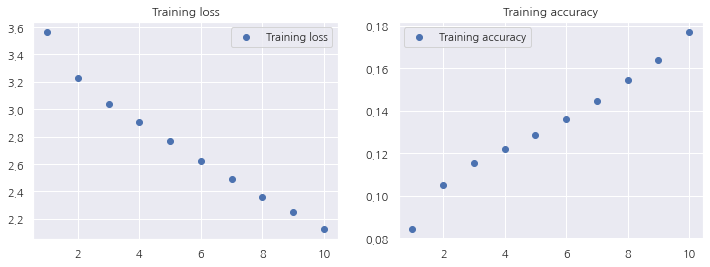

In [36]:
# loss와 acc 시각화
def visualize_training_results(losses, accuracies):
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, 'bo', label='Training loss')
    plt.title('Training loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, 'bo', label='Training accuracy')
    plt.title('Training accuracy')
    plt.legend()

    plt.show()

visualize_training_results(losses, accuracies)


### 결론

시각화 자료를 통해 모델이 노드에서 요구하는 평가 기준에 부합한지 평가했다.
사실 텍스트 생성모델에서 정확도는 크게 영향력이 있고, 신빙성이 있는 지표는 아니다.
하지만, Loss는 점점 비교적 가파르게 감소하는 모습을 보였고, accuracy도 꽤 안정적으로 증가하는 모습을 보인다.

이로서 수치상으로 봤을 때, 학습 자체는 성공적으로 이루어진 것으로 보인다.

### 모델에 대해서
노드에서 주어진 모델에서 딱 3가지를 변경하려고 시도했다.
- lstm vs gru
- BahdanauAttention vs LuongAttention
- Dropout

각각에 대해서 다음의 결과가 반영되었다.

Encoder: gru
Decoder: gru, luong attention
dropout: 0.3 each

사실 내 계획은 Encoder에 lstm을 넣는 것이었으나 OOM 문제가 발생했다.

그럼에도 불구하고, 사실상 어텐션만 변경했을 뿐인데,  
과거 수치 대비 정확도가 7% 증가했고 loss는 1.1이 감소했다.

나름 유의미한 결과를 냈다고 생각한다.  
물론 시간이 더 있었으면, 개선할 수 있었을 것이다.

## 어텐션 맵 그리기

In [37]:
# 텍스트 전처리와 inference 과정을 거친다.
def evaluate(sentence, encoder, decoder):
    # 데이터 준비 과정
    attention = np.zeros((tensor_en.shape[-1], tensor_ko.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    mecab = Mecab()
    sentence = mecab.morphs(sentence)
    
    inputs = tokenizer_ko.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=tensor_ko.shape[-1],
                                                           padding='post')

    # 인퍼런스 루틴
    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([tokenizer_en.word_index['<start>']], 0)
                            
    for t in range(tensor_en.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()                                           

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += tokenizer_en.index_word[predicted_id] + ' '

        if tokenizer_en.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    # 시각화를 위한 데이터 리턴
    return result, sentence, attention

# 시각화를 위한 함수
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [38]:
# 위 함수들을 이용해서 번역 및 그 결과에 대한 시각화를 제공하는 함수
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))

Input: ['오늘', '은', '월요일', '이', '다', '.']
Predicted translation: today show this morning . <end> 


/tmp/ipykernel_630/2279439154.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_630/2279439154.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


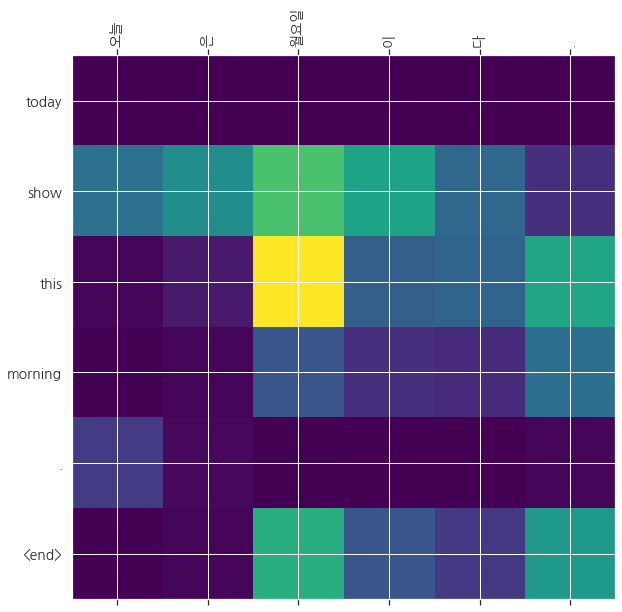

In [45]:
'''
## 예문 ##
K1) 오바마는 대통령이다.
K2) 시민들은 도시 속에 산다.
K3) 커피는 필요 없다.
K4) 일곱 명의 사망자가 발생했다.

## 제출 ##
E1) obama is the president . <end>
E2) people are victims of the city . <end>
E2) the price is not enough . <end>
E2) seven people have died . <end>
'''
# 각 예문에 대한 번역 결과 및 시각화 결과를 출력한다.
# sens = ['오바마는 대통령이다.', '시민들은 도시 속에 산다.', '커피는 필요 없다.', '일곱 명의 사망자가 발생했다.']
sens = ['오늘은 월요일이다.']
for sen in sens:
    translate(sen, encoder, decoder)

## 결론

비슷하게 의미를 정확하게 추론시킨 것 같지만, 아직 부족한 점이 많다.  
1epochs당 10분이라 소요시간 대비 결과가 매우 실망스럽다.  

좀 더 적절한 장비와 더 많은 시간이 주었졌다면, 좀 더 잘 나왔을 것이다.

